In [1]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import yfinance as yf

In [2]:
RISKY_ASSETS = ['AAPL']
START_DATE = '2014-01-01'
END_DATE = '2024-05-24'


[*********************100%%**********************]  1 of 1 completed

Downloaded 2616 rows of data.


<Axes: title={'center': 'Stock prices of the considered assets'}, xlabel='Date'>

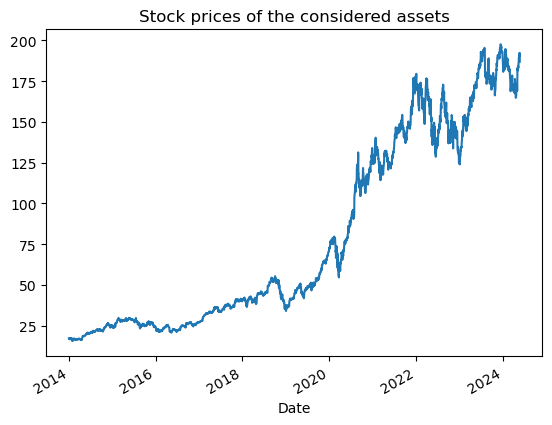

In [3]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
prices_df['Adj Close'].plot(title='Stock prices of the considered assets')

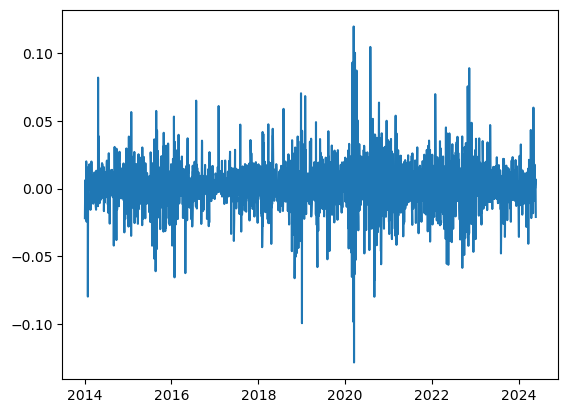

In [4]:
returns = prices_df['Adj Close'].pct_change().dropna()
plt.plot(returns)
plt.show()

In [7]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

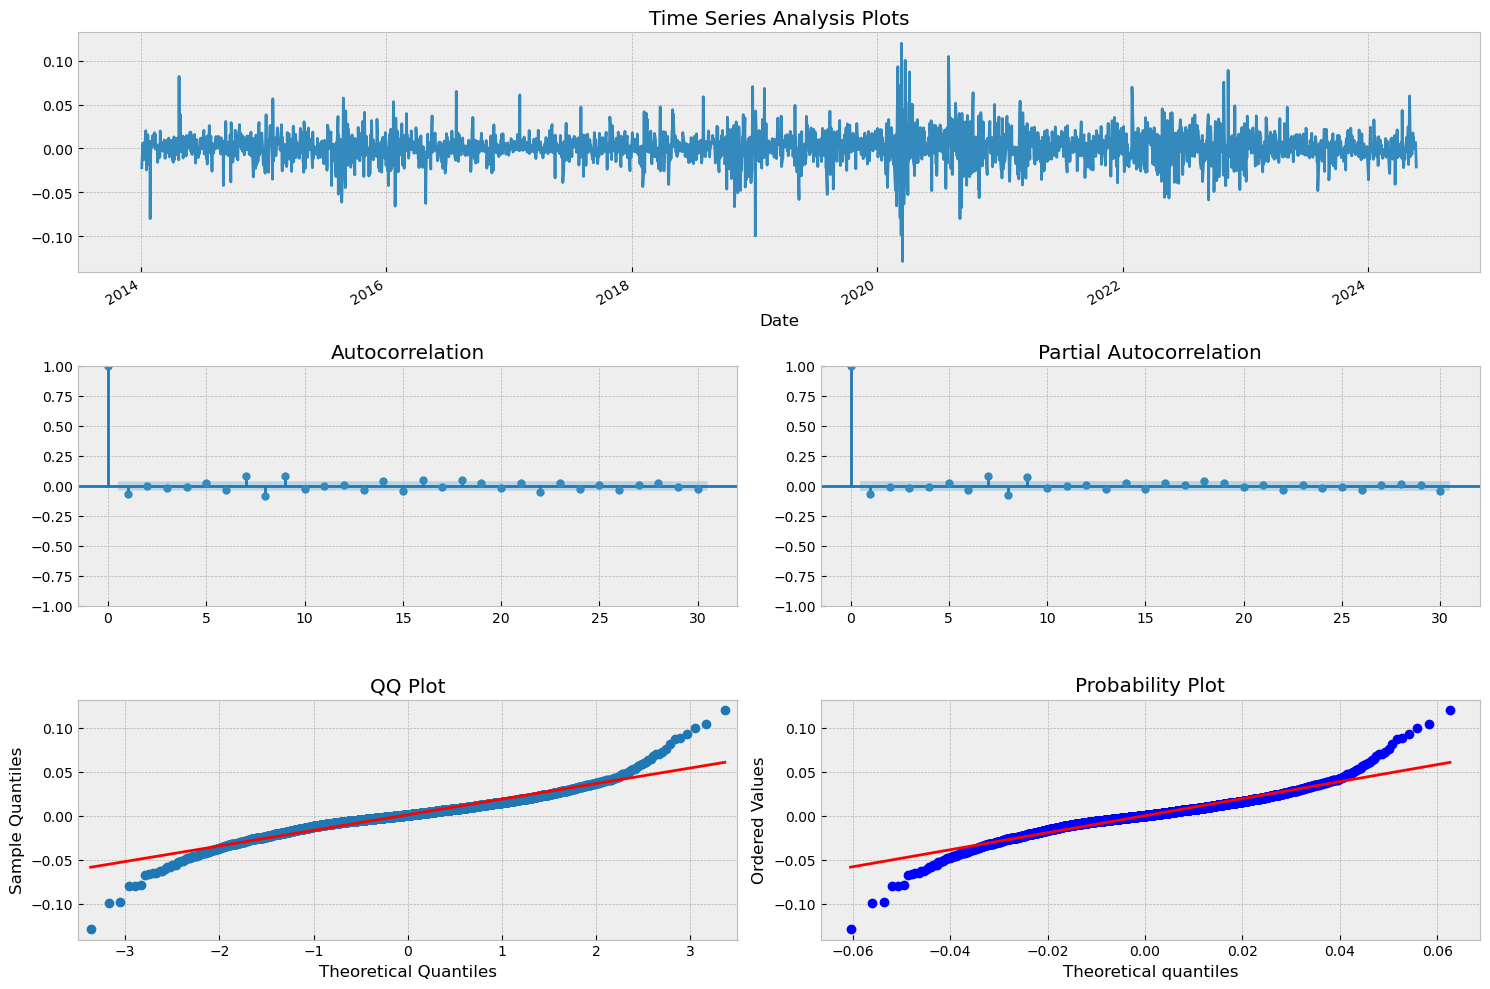

In [6]:
tsplot(returns, lags=30)

In [13]:
returns.head()

Date
2014-01-03   -0.021966
2014-01-06    0.005453
2014-01-07   -0.007152
2014-01-08    0.006333
2014-01-09   -0.012771
Name: Adj Close, dtype: float64

In [19]:
pip install pmdarima


  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ac/f8/6c9364602b13f0dba129b53acd1344859690911a4d5021560d9fd6aa087f/pmdarima-2.0.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/18/ec/f47a721071d084d6c2b6783eb8d058b964b1450cb708d920d0d792f42001/Cython-3.0.10-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   -------------------- ------------------- 317.4/614.7 kB 6.5 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 7.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.4/2.8 MB 8.1 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.8 MB 12.6 MB/s eta 0:00:01
   ----------------------- ---------------- 1.7/2.8 MB 11.7 MB/s eta 0:00:01
   ------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [34]:

import pmdarima as pm

# Fit the best ARIMA model
model = pm.auto_arima(returns, 
                      start_p=1, start_q=1,
                      max_p=30, max_q=30,
                      seasonal=False,
                      d=1,  # Order of differencing
                      trace=True,  # Print the progress
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# Print the summary of the best model
print(model.summary())



print('\nEstimated coefficients:', model.params())
print('\nTrue alpha = %s | True order = %s' % (a, true_order))



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11675.056, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12532.759, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11677.055, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12846.844, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-13025.097, Time=0.34 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-13172.720, Time=0.48 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-13224.775, Time=0.42 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-13352.663, Time=0.63 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-13356.284, Time=0.62 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=-13444.513, Time=1.09 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=-13456.836, Time=0.54 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=-13475.727, Time=2.80 sec
 ARIMA(11,1,0)(0,0

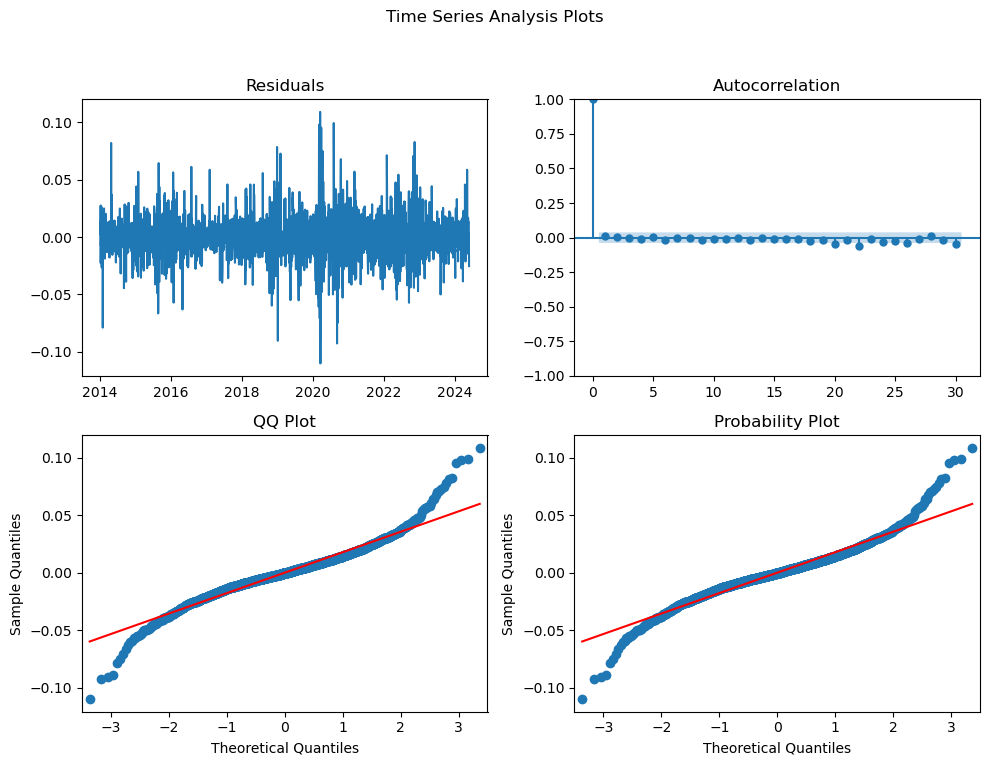

In [26]:
# Get residuals
residuals = model.resid()

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Time Series Analysis Plots')

# Time Series Plot
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Residuals')

# Autocorrelation Plot
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

# QQ Plot
sm.qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title('QQ Plot')

# Probability Plot
sm.ProbPlot(residuals).qqplot(line='s', ax=axes[1, 1])
axes[1, 1].set_title('Probability Plot')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [33]:
# Fit the best ARIMA model
model = pm.auto_arima(returns, 
                      start_p=1, start_q=1,
                      max_p=30, max_q=30,
                      seasonal=False,
                      d=0,  # Order of differencing
                      trace=True,  # Print the progress
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# Print the summary of the best model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-13655.528, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-13649.609, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-13657.501, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-13657.530, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-13655.529, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-13653.527, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-13666.389, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-13657.065, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-13664.474, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-13664.451, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-13666.258, Time=0.45 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-13662.392, Time=0.42 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 2.037 seconds
                               SARIMAX Results                  

0.0


TypeError: float() argument must be a string or a real number, not 'method'